#  Makine Öğrenmesi ile Müşteri Segmentasyonu

- RFM projesindeki retail veri setindeki müşterileri k-means ile segmentlere ayırınız.
- RFM metrikleri üzerinden uygulayınız.

## Veri Seti Detayı

- **InvoiceNo:** Fatura numarası. Nominal. Her işleme benzersiz şekilde atanan 6 basamaklı bir integral numarası. Bu kod 'c' harfiyle başlıyorsa, iptal gerçekleşmiştir.
- **StockCode:** Ürün kodu. Nominal. Her farklı ürüne benzersiz şekilde atanmış 5 basamaklı bir integral numarası
- **Description:** Ürün (öğe) adı. Nominal.
- **Quantity:** İşlem başına her bir ürünün (kalem) miktarı. Sayısal.
- **InvoiceDate:** Bir işlemin oluşturulduğu gün ve saat. Sayısal. 
- **UnitPrice:** Birim fiyat. Sayısal. Birim başına ürün fiyatı (Â£).
- **CustomerID:** Müşteri numarası. Nominal. Her müşteriye benzersiz şekilde atanmış 5 basamaklı bir integral numarası.
- **Country:** Ülke adı. Nominal. Müşterinin ikamet ettiği ülkenin adı.


In [211]:
# Gerekli kütüphanelerin yüklenmesi
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [212]:
# Veri setinin okutulması (2010-2011 yılına ait veriler üzerinden gidilecek)
df = pd.read_excel('online_retail_II.xlsx', sheet_name = "Year 2010-2011")

In [213]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [214]:
# Gözlem ve değişken sayısı
df.shape

(541910, 8)

In [215]:
# değişkenlerin isimleri
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [216]:
# info() metoduyla sutunlardaki toplam dolu değer adetini, sutunların veri tiplerinin ne olduğuna 
# ve toplamda hafızada ne kadar değer tuttuğuna bakalım.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [217]:
# Sayısal değişkenlerin tanımlayıcı istatistikleri
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
Price,541910.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
Customer ID,406830.00,15287.68,1713.60,12346.00,13953.00,15152.00,16791.00,18287.00


### Veri Setinde Kaç Kategorik ve Sayısal Değişken Var?

In [218]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Sayısal Değişkenlerin Sayısı: ", len(numerical_feats))
print("Sayısal Değişkenler: ", list(numerical_feats))
print(""" """)
categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Kategorik Değişkenlerin Sayısı: ", len(categorical_feats))
print("Kategorik Değişkenler: ", list(categorical_feats))

Sayısal Değişkenlerin Sayısı:  4
Sayısal Değişkenler:  ['Quantity', 'InvoiceDate', 'Price', 'Customer ID']
 
Kategorik Değişkenlerin Sayısı:  4
Kategorik Değişkenler:  ['Invoice', 'StockCode', 'Description', 'Country']


### Invoice değişkeninde iptal edilen işlemlerin dataframe den çıkarılması

In [219]:
print("İptal edilen işlem sayısı : ",len(df[df["Invoice"].astype("str").str.get(0)=="C"]))

İptal edilen işlem sayısı :  9288


In [220]:
# C ile başlayan Fatura numaralarını içermeyen dataframe
df[df["Invoice"].astype("str").str.get(0)=="C"].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.00,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.00,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.00,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.00,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.00,United Kingdom


In [221]:
# C ile başlamayan Invoice değerleri içeren df, esas df olarak kabul edildi.¶
df = df[~df["Invoice"].str.contains("C",na=False)]

In [222]:
df.shape

(532622, 8)

### Missing Values

In [223]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    134697
Country             0
dtype: int64

In [224]:
df.dropna(inplace=True)

In [225]:
df.shape

(397925, 8)

### Veri Setinin İncelenmesi

In [226]:
## Veri seti boş değerlerden ve iptal edilen fatura işlemlerinden arındı
## Artık çeşitli gözlemler yapmaya başlıyabiliriz

In [227]:
# Eşsiz ürünler
df["Description"].nunique()

3877

In [228]:
# Her bir ürünün sayıları
df["Description"].value_counts().head() 

WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1724
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1397
Name: Description, dtype: int64

In [229]:
# En çok satanlar
df.groupby("Description").agg({"Quantity":sum}).sort_values(by="Quantity", ascending=False).head()

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
JUMBO BAG RED RETROSPOT,46181
WHITE HANGING HEART T-LIGHT HOLDER,36725


In [230]:
# Eşsiz faturalar
df["Invoice"].nunique()

18536

In [231]:
# Alınan ürünün miktarı * Birim Fiyat
df["Total_price"]=df["Quantity"]*df["Price"]

In [232]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34


In [233]:
# En yüksek tutara sahip ilk 5 fatura
df.groupby("Invoice").agg({"Total_price":sum}).sort_values(by="Total_price", ascending=False).head(5)

,Total_price
Invoice,
581483,168469.60
541431,77183.60
556444,38970.00
567423,31698.16
556917,22775.93


In [234]:
# En yüksek harcamanın yapıldığı ilk 5 ülke
df.groupby("Country").agg({"Total_price":sum}).sort_values(by="Total_price", ascending=False).head(5)

,Total_price
Country,
United Kingdom,7308391.55
Netherlands,285446.34
EIRE,265545.90
Germany,228867.14
France,209042.05


### RFM METRİKLERİNİN EKLENMESİ

In [235]:
import datetime as dt
today_date=dt.datetime(2011,12,10)

In [236]:
# Recency -> En son işlem yapılan tarihten itibaren kaç gün geçtiği
# Frequency -> Ne kadar sıklıkla işlem yapıldığı
# Monetary -> Toplam harcanılan miktarı
rfm = df.groupby(['Customer ID']).agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                       'Invoice': 'nunique',
                                       'Total_price': 'sum'})

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'Total_price': 'Monetary'}, inplace=True)

In [237]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,325,1,77183.60
12347.00,2,7,4310.00
12348.00,75,4,1797.24
12349.00,18,1,1757.55
12350.00,310,1,334.40


### K-Means

Recency's: Skew: 1.2457061452812261, : SkewtestResult(statistic=26.611169084340677, pvalue=5.040901564576977e-156)
Frequency's: Skew: 12.095844462595078, : SkewtestResult(statistic=74.69605833000436, pvalue=0.0)
Monetary's: Skew: 19.320305448600593, : SkewtestResult(statistic=85.00749133020068, pvalue=0.0)


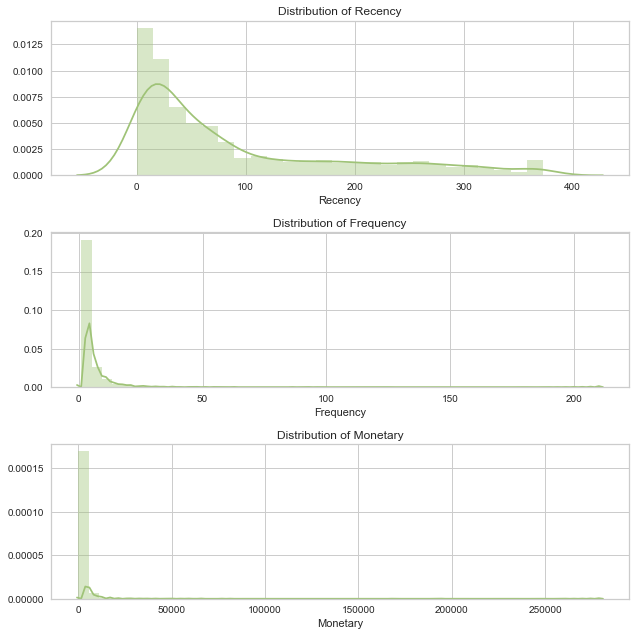

In [238]:
#SKEWNESS
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(rfm,'Recency')
plt.subplot(3, 1, 2)
check_skew(rfm,'Frequency')
plt.subplot(3, 1, 3)
check_skew(rfm,'Monetary')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [239]:
# Log transformation normal dağılımın sağlanması için
rfm_log = pd.DataFrame()
rfm_log['Recency']=np.log1p(rfm['Recency'])
rfm_log['Frequency']=np.log1p(rfm['Frequency'])
rfm_log['Monetary']=np.log1p(rfm['Monetary'])
rfm_log.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,5.79,0.69,11.25
12347.00,1.10,2.08,8.37
12348.00,4.33,1.61,7.49
12349.00,2.94,0.69,7.47
12350.00,5.74,0.69,5.82


Recency's: Skew: -0.46659538819323154, : SkewtestResult(statistic=-11.972286003517658, pvalue=4.964175502238313e-33)
Frequency's: Skew: 1.208499362603212, : SkewtestResult(statistic=26.05493354703196, pvalue=1.1828557271553937e-149)
Monetary's: Skew: 0.3604260825179613, : SkewtestResult(statistic=9.420053104901962, pvalue=4.508599383670575e-21)


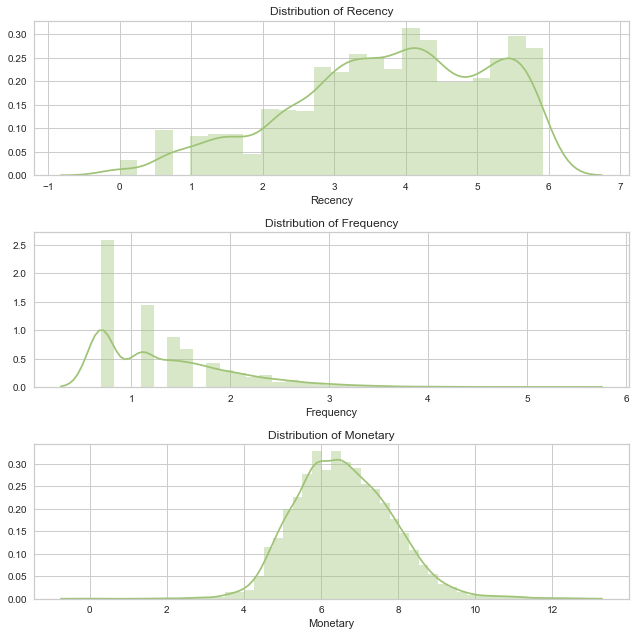

In [240]:
# çarpıklık için grafiklerin tekrar çizilmesi
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(rfm_log,'Recency')
plt.subplot(3, 1, 2)
check_skew(rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(rfm_log,'Monetary')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [247]:

# Scaling
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(rfm_log )
normalized=transformer.transform(rfm_log )
normalized_rfm=pd.DataFrame(normalized,columns=rfm.columns)
normalized_rfm.head()

,Recency,Frequency,Monetary
0,0.46,0.05,0.89
1,0.13,0.24,0.96
2,0.49,0.18,0.85
3,0.37,0.09,0.93
4,0.70,0.08,0.71


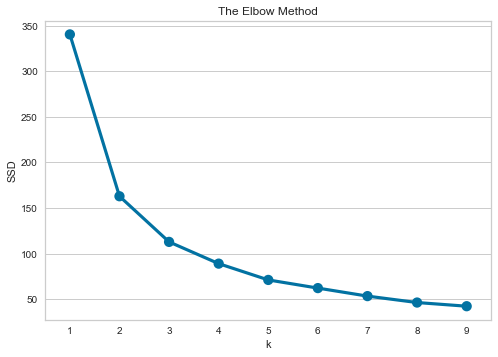

In [248]:
#Elbow Metodu ile noktaların her bir K değerine göre, küme merkezine olan uzaklıklarının karelerinin toplamı(SSD) gösterilmektedir.
#Eğimin en hızlı değiştiği nokta yani dirseklendiği nokta küme sayısı olarak belirlenir. (optimum k=3)
ssd = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sc_rfm)
    ssd[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSD')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

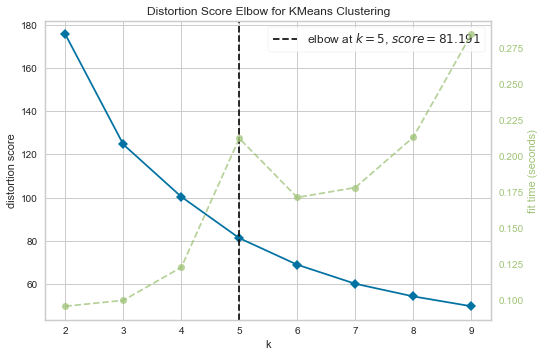

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [249]:
# Yukarıda grafiği elle yapmıştık. Yellowbrick kütüphanesinin KElbowVisualizer fonksiyonu ile de dirseklendiği noktayı görebiliriz.
# Distortion Score=SSD=Error
# Bu metod dirsek yöntemi ile fit etme süresi kesişimini önerir.(optimum k=5)
kmeans=KMeans()
visu=KElbowVisualizer(kmeans, k=(2,10))
visu.fit(sc_rfm)
visu.poof()

In [276]:
# K=4 ile devam edebiliriz.
# Kümeleme yapılıp, segmentler bulunur
k_means = KMeans(n_clusters = 4).fit(sc_rfm)
segments=k_means.labels_
segments

array([0, 1, 3, ..., 2, 1, 3], dtype=int32)

In [277]:
# Genel bir analiz için dataframe oluşturalım
rfm["Segment"] = segments
rfm=rfm.reset_index(drop=True)
rfm.head()

,Recency,Frequency,Monetary,Segment
0,325,1,77183.60,0
1,2,7,4310.00,1
2,75,4,1797.24,3
3,18,1,1757.55,2
4,310,1,334.40,0


# RAPORLAMA

In [278]:
rfm[["Segment","Recency","Frequency","Monetary"]].groupby("Segment").agg(["min","max","mean","count"])

Recency                   Frequency                  Monetary  \
            min  max   mean count       min  max  mean count      min   
Segment                                                                 
0            77  373 208.29  1480         1    7  1.58  1480     3.75   
1             0   17   5.28   741         1  210 11.31   741   161.03   
2             3   79  37.43  1160         1    4  1.67  1160     0.00   
3            12  372  45.70   958         2   63  6.13   958   306.72   

                                 
              max    mean count  
Segment                          
0        77183.60  594.23  1480  
1       280206.02 6434.17   741  
2         6207.67  505.15  1160  
3       124914.53 2795.69   958

**Segment 0**

- Bu grupta 1480 müşteri bulunmaktadır.
- Son harcamaları ortalama 208.29 gün öncedir.
- Alışveriş sıklıkları ortalama 1.58'dir.
- Kişi başı toplam harcama ortalama 594.23 sterlindir.


**Segment 1**

- Bu grupta 741 müşteri bulunmaktadır.
- Son harcamaları ortalama 5.28 gün öncedir.
- Alışveriş sıklıkları ortalama 11.31'dir.
- Kişi başı toplam harcama ortalama 6434.17 sterlindir.

**Segment 2**
- Bu grupta 1160 müşteri bulunmaktadır.
- Son harcamaları ortalama 37.43 gün öncedir.
- Alışveriş sıklıkları ortalama 1.67'dir.
- Kişi başı toplam harcama ortalama 505.15 sterlindir.


**Segment 3**
- Bu grupta 958 müşteri bulunmaktadır.
- Son harcamaları ortalama 45.70 gün öncedir.
- Alışveriş sıklıkları ortalama 6.13'dir.
- Kişi başı toplam harcama ortalama 2795.69 sterlindir.


**Sonuç**

 KMeans analizine göre 
 
 - en çok harcama yapan,en sık alışveriş yapan ve en yakın zamanda alışveriş yapan müşterilerin 1. grupta olduğu gözlemlenmiştir.
 
 - 0 ve 2. grup alışveriş sıklığı ve kişi başı ortalama harcamaları bakımından benzerlik gösteriyorken, ortalama son harcama günü açısından farklılık göstermektedir.
